#### Imports

In [39]:
import os
from PIL import Image
import pandas as pd
import torch
from torch import optim
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

### Device Setting

In [30]:
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"GPU is available with {num_gpus} device(s).")

    # Get the name of the current GPU
    current_gpu = torch.cuda.get_device_name(0)  # Assuming the first GPU is used
    print(f"Current GPU: {current_gpu}")
else:
    print("GPU is not available. Using CPU.")

GPU is not available. Using CPU.


In [31]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the first available GPU
else:
    device = torch.device("cpu")  # If no GPU is available, use CPU

#### Dataset class

In [32]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, img_folder, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_folder = img_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_folder, f"{self.df['unique_id'].iloc[idx]}.jpg")
        image = Image.open(img_name)  # stack overflow .convert("RGB")

        target = torch.tensor(self.df['loss_percentage'].iloc[idx], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, target

In [33]:
df = 'filtered_data.csv'
img_folder_path = 'SolarPanelSoilingImageDataset\Solar_Panel_Soiling_Image_dataset\Pytorch_data/'

In [41]:
transform = transforms.Compose([
    transforms.Resize((192, 192)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [42]:
custom_dataset = CustomDataset(csv_file='filtered_data.csv', img_folder=img_folder_path, transform=transform)


In [43]:
dataloader = DataLoader(custom_dataset, batch_size=32, shuffle=False)


### Visualize the loaded data

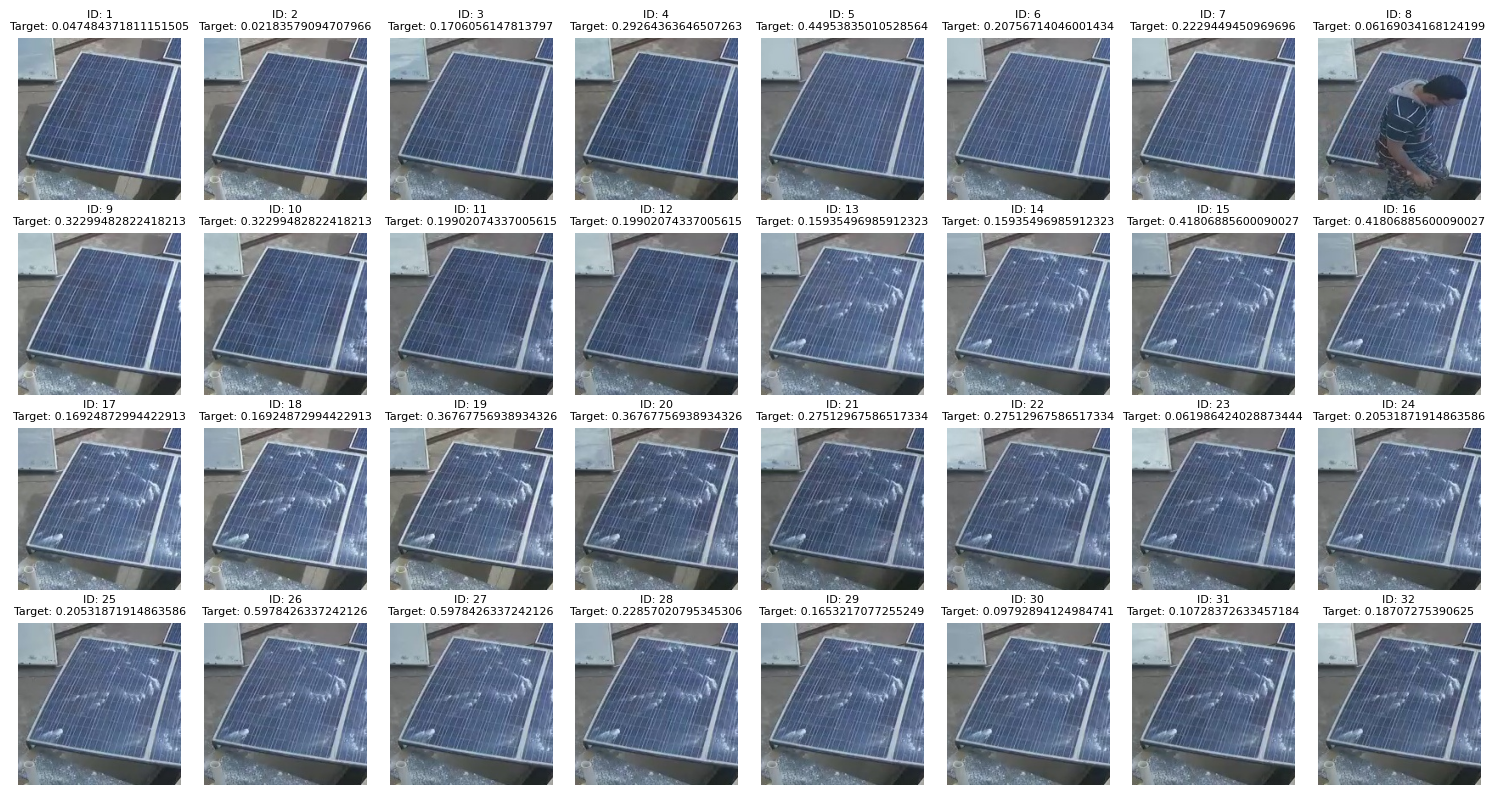

In [44]:
images, targets = next(iter(dataloader))

# Convert images to numpy arrays
np_images = images.numpy()

# Define the size of the grid
num_rows = 4
num_cols = 8

# Set the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Visualize each image along with its target and ID from the folder
for i in range(num_rows * num_cols):
    image = np.transpose(np_images[i], (1, 2, 0))  # Change the order of dimensions for displaying with matplotlib
    target = targets[i].item()
    image_id = custom_dataset.df['unique_id'].iloc[i]

    axes[i].imshow(image)
    axes[i].set_title(f'ID: {image_id}\nTarget: {target}', fontsize=8)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### NN Architecture

In [38]:
class RegressionCNN(nn.Module):
    def __init__(self):
        super(RegressionCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 48 * 48, 512)
        self.fc2 = nn.Linear(512, 1)  # Output dimension is 1 for regression

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the input for the fully connected layers
        x = x.view(-1, 128 * 48 * 48)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [40]:
def train_regression_model(model, dataloader, num_epochs=10, learning_rate=0.001):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    loss_values = []
    r2_values = []

    for epoch in range(num_epochs):
        model.train()

        running_loss = 0.0
        targets = []
        predictions = []

        with tqdm(total=len(dataloader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
            for inputs, targets_batch in dataloader:
                inputs, targets_batch = inputs.to(device), targets_batch.to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets_batch)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                # Collect targets and predictions for R-squared calculation
                targets.extend(targets_batch.cpu().numpy())
                predictions.extend(outputs.squeeze().detach().cpu().numpy())

                pbar.update(1)

            epoch_loss = running_loss / len(dataloader)
            r2 = r2_score(targets, predictions)

            loss_values.append(epoch_loss)
            r2_values.append(r2)

            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, R-squared: {r2:.4f}')

    # Plotting loss and R-squared
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), loss_values, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), r2_values, label='R-squared')
    plt.xlabel('Epoch')
    plt.ylabel('R-squared')
    plt.title('R-squared over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

#### Train Test Split

In [25]:
train_dataset, test_dataset = train_test_split(custom_dataset, test_size=0.2)

# Create DataLoader instances for training and testing sets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [26]:
model = RegressionCNN()


In [29]:
train_regression(model, train_dataloader, learning_rate=0.001, epochs=10)

C:\Python\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 